In [2]:
!pip install python_speech_features


  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=81c3424469a74cba419dccbdfc249488d53423e4a808de96628c9d96937f81e7
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


Commands: ['up' 'yes' 'no' 'stop' 'go' 'left' 'right' 'down']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/stop/f19c1390_nohash_3.wav', shape=(), dtype=string)
Training set size 6400
Validation set size 1000
Test set size 600
label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)


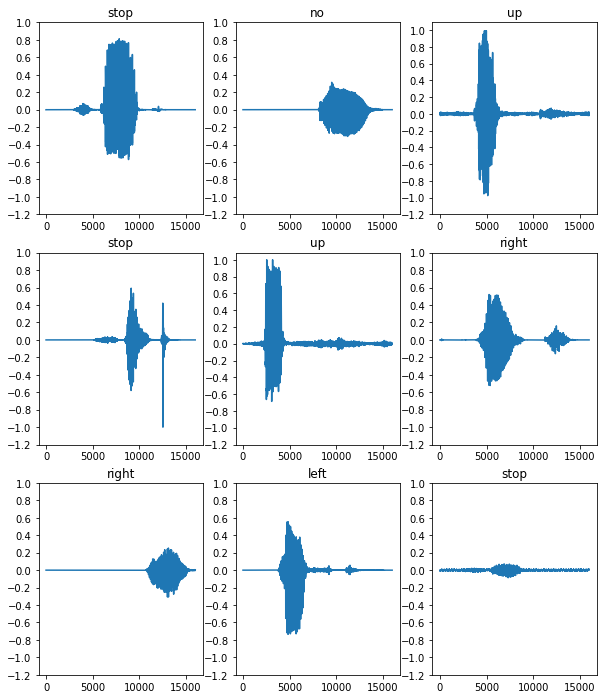

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


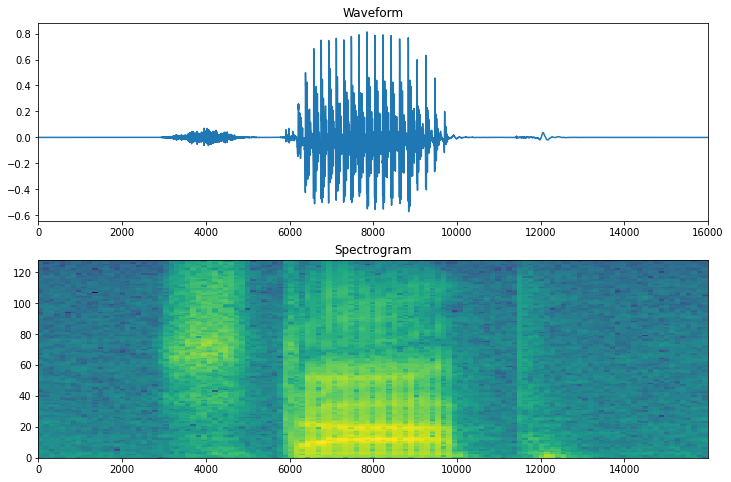

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log


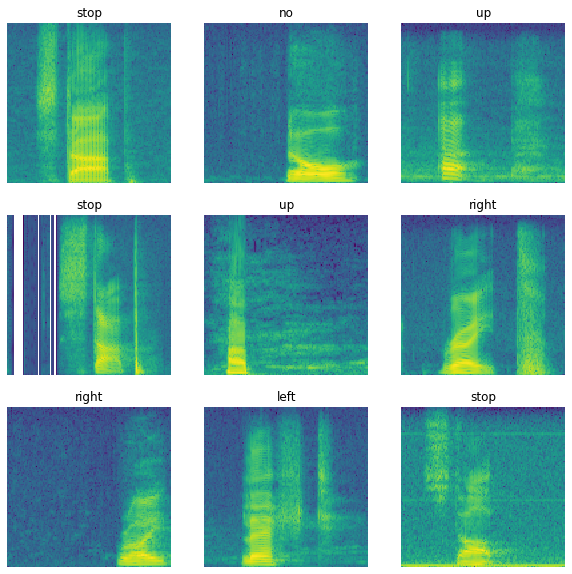

label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)
label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)
test_ds
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


In [13]:
import os
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Flatten,LSTM,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.applications.resnet import ResNet50
from keras.utils.np_utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
 
import librosa as lr
 
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
 
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)
 
 
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])
 
 
 
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 1000]
test_files = filenames[-600:]
 
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
 
 
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)
 
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
 
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 
 
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  print("label")
  print(label)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  print("waveform")
  print(waveform)
  return waveform, label
 
 
 
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
 
 
 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
 
plt.show()
 
 
 
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
 
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)
 
  return spectrogram
 
 
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)
 
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))
 
 
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
 
 
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
 
 
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id
 
 
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
 
 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()
 
 
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds
 
 
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
test_ds_label=test_ds
print("test_ds")
print(type(train_ds)) 
 
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size) 
 
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [3]:
#CNN_code_implementation_in_this_block

In [14]:
#TRue_labels_of_test_data
test_ds_label = test_ds_label.batch(len(test_files))
#val_ds = val_ds.batch(batch_size)
#test_ds = test_ds.batch(batch_size) 
 
test_ds_label= test_ds_label.cache().prefetch(AUTOTUNE)
iterator_1 = test_ds_label.__iter__()
next_element_1 = iterator_1.get_next()
pt_1 = next_element_1[0]
true_label = next_element_1[1]
print(pt_1.numpy().shape)
print(true_label.numpy())
print(true_label.shape )

(600, 124, 129, 1)
[0 1 1 6 1 1 7 5 2 0 3 5 2 1 2 4 7 1 5 7 5 4 0 2 2 7 4 0 7 0 7 1 2 2 7 5 7
 6 7 2 1 2 3 0 0 4 7 4 5 7 1 0 3 5 0 2 5 3 1 6 6 1 0 7 4 5 6 3 2 2 6 7 6 1
 4 1 1 4 0 5 2 6 3 0 1 0 4 3 3 3 0 6 6 4 0 5 6 4 2 4 0 1 7 6 2 6 3 6 6 5 4
 2 5 0 7 4 4 6 2 4 0 2 5 1 0 4 2 1 6 2 6 4 5 1 6 5 4 5 6 1 7 5 5 6 6 5 0 5
 1 0 3 5 4 1 0 5 1 5 0 6 2 1 0 6 2 2 0 5 7 3 6 6 3 4 6 1 3 4 1 4 2 7 2 7 0
 0 0 5 0 5 4 6 2 7 7 1 1 7 0 2 7 0 2 5 7 1 0 1 4 0 4 7 6 1 5 2 3 7 5 0 0 7
 4 0 2 7 6 7 4 0 5 3 3 2 5 2 5 1 1 3 7 2 2 3 1 7 0 4 5 6 0 5 4 5 6 7 6 4 7
 2 7 0 5 4 0 1 1 6 7 1 1 5 3 7 1 7 1 2 4 4 2 5 4 3 6 1 5 0 3 1 1 1 4 2 7 0
 1 5 2 5 7 6 5 1 4 7 4 3 0 5 0 3 2 0 4 6 5 2 6 3 1 0 1 6 4 2 1 5 3 0 2 3 3
 0 1 6 5 7 1 2 7 7 4 6 5 6 5 6 1 2 2 6 5 3 2 5 1 5 3 1 0 1 7 4 1 1 4 4 2 7
 5 1 4 2 4 1 3 1 7 2 0 0 2 5 3 3 2 0 3 7 3 0 1 2 5 4 7 7 4 5 0 0 4 2 1 7 1
 5 7 2 7 1 4 3 6 1 0 4 4 2 5 3 2 6 7 4 0 7 7 2 5 6 4 6 1 7 2 0 1 0 6 7 6 7
 3 6 3 3 3 2 1 3 5 6 3 0 3 6 0 5 2 5 3 4 3 7 0 6 4 2 6 2 2 2 7 7 3 3 3 7 0
 1 2 3

In [15]:
len(true_label)

600

In [16]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Flatten,LSTM,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint

import librosa as lr

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


In [18]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

Input shape: (124, 129, 1)


In [8]:
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping

In [ ]:
# plot loss during training
import matplotlib.pyplot as pyplot
#pyplot.subplot(211)
#pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
pyplot.legend()
pyplot.show()
plt.savefig('IMAGE.png')
# plot accuracy during training
#pyplot.subplot(212)
#pyplot.title('Accuracy')
#pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
#pyplot.legend()
#pyplot.show()
#plt.savefig('IMAGE1.png')

In [ ]:
#pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
plt.savefig('IMAGE1.png')

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [30]:
y_predict=model.predict(test_ds)
y_pred_labels = np.argmax(y_predict, axis=1)
len(y_pred_labels), type(y_pred_labels)

(600, numpy.ndarray)

In [31]:
y_pred_labels

array([0, 1, 1, 6, 1, 1, 0, 5, 2, 0, 3, 5, 2, 1, 2, 4, 4, 1, 5, 7, 5, 4,
       0, 2, 2, 7, 4, 0, 4, 0, 7, 1, 2, 2, 7, 5, 7, 6, 7, 2, 1, 4, 3, 0,
       3, 4, 7, 2, 5, 7, 1, 0, 3, 5, 0, 2, 5, 3, 1, 6, 6, 1, 0, 7, 4, 5,
       6, 3, 2, 2, 6, 7, 6, 1, 2, 1, 1, 4, 0, 5, 4, 6, 3, 0, 1, 3, 4, 3,
       3, 3, 0, 6, 6, 4, 0, 5, 6, 4, 2, 4, 0, 1, 7, 6, 2, 6, 3, 6, 6, 5,
       4, 2, 5, 0, 3, 4, 4, 6, 2, 4, 0, 2, 6, 1, 0, 4, 2, 5, 6, 2, 6, 4,
       5, 1, 6, 5, 4, 5, 6, 1, 7, 5, 5, 6, 6, 5, 0, 5, 1, 0, 0, 5, 4, 1,
       0, 5, 1, 5, 0, 6, 2, 1, 0, 6, 2, 2, 0, 5, 7, 5, 6, 6, 3, 4, 6, 1,
       3, 4, 1, 7, 7, 2, 2, 7, 0, 3, 0, 5, 0, 5, 3, 6, 2, 7, 7, 1, 1, 7,
       0, 2, 7, 0, 2, 5, 7, 1, 0, 1, 4, 0, 4, 7, 6, 1, 5, 2, 3, 7, 5, 0,
       0, 7, 4, 0, 2, 7, 6, 7, 4, 0, 5, 3, 3, 2, 5, 2, 0, 1, 1, 3, 7, 2,
       2, 3, 1, 7, 6, 6, 5, 6, 0, 5, 4, 5, 6, 7, 6, 4, 2, 2, 2, 0, 5, 4,
       0, 1, 1, 6, 7, 1, 1, 5, 3, 7, 1, 7, 1, 2, 4, 4, 2, 5, 4, 3, 6, 1,
       5, 0, 3, 1, 1, 1, 0, 2, 7, 7, 1, 5, 2, 5, 7,

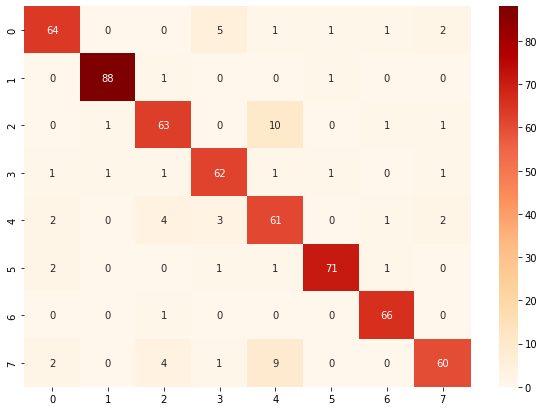

In [32]:
import seaborn as sn
C_M = confusion_matrix(true_label,y_pred_labels)
plt.figure(figsize = (10,7))
sn.heatmap(C_M, annot=True,cmap="OrRd")

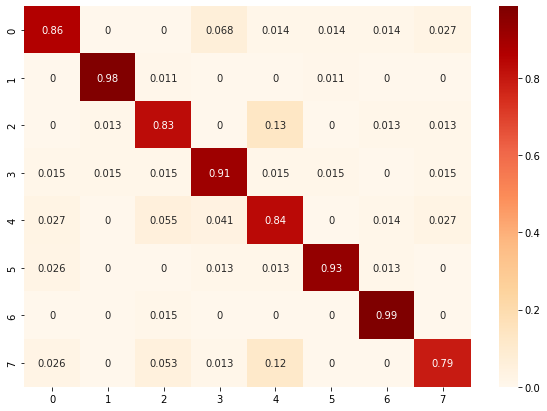

In [33]:
#Normalized

C_M=C_M.astype(np.float32)
Normalized_CM=np.empty([8, 8])
for i in range(8):
    for j in range(8):
        Normalized_CM[i,j]=C_M[i,j]/(C_M[i,:].sum())    
#a[0,:]=a[0,:]/(a[0,:].sum())
plt.figure(figsize = (10,7))
sn.heatmap(Normalized_CM, annot=True,cmap="OrRd")